# Perform TF analysis to identify clusters that may be targetted by TFs

In [1]:
from scimotf import SciMotf_Doro
import pandas as pd
import numpy as np

base_dir = '../data/'
data_dir = f'{base_dir}sircle/F3_regulatory_clustering/'
output_dir = f'{base_dir}sircle/F4_TF_analysis/'
fig_dir = '../figures/'
supp_dir = f'{base_dir}raw_downloads/supps/'
gene_name = 'hgnc_symbol'
save_fig = False
test_title = 'all_patients_ccRCC'
run_label = 'P0.5-R1.0-M0.1'

In [2]:
rcm_file = f'{data_dir}RCM_all_patients_ccRCC_P0.5-R1.0-M0.1-GENES.csv'
tf_file = supp_dir + 'dorothea_hs_ABCD.csv'
mo = SciMotf_Doro(doro_file=tf_file, cluster_file=rcm_file, cluster_gene_id='external_gene_name', # got to match motif
                 padj_protein='padj_protein', logfc_protein='logFC_protein', padj_rna='padj_rna',
                  logfc_rna='logFC_rna', output_dir=output_dir)

df = mo.run(['A'], rcm_clusters=["TMDE", "TMDS", "MDS", "MDS_TMDE", "MDE", "MDE_TMDS", "TPDE", "TPDE_TMDS", "TPDS", "TPDS_TMDE",])
df.to_csv(f'{output_dir}scimotif_DORO_A.csv')

     Unnamed: 0  tf confidence  target  mor
480         481  AR          A   ABCE1    1
481         482  AR          A  ACAD10    1
482         483  AR          A    ACP3    1
483         484  AR          A    AHSG    1
484         485  AR          A  AKR1B1    1
--------------------------------------------------------------------------------
WARN: no background ID set, using all genes in the supplied DF as the background.
Number of genes: 	6718	
--------------------------------------------------------------------------------


In [9]:
def plot_cluster_tf(filename, gene_ratio_min=1, padj_max=0.05, title='', fig_dir='',
                    label_font_size=9, figsize=(3, 3), axis_font_size=6,
                    rcm_labels=["MDS", "MDS_TMDE", "MDE", "MDE_TMDS", "TMDE", "TMDS", "TPDE", "TPDE_TMDS", "TPDS", "TPDS_TMDE"],
                    save_fig=True):
    """

    Parameters
    ----------
    filename
    gene_ratio
    count_column
    padj
    overlap_column
    id_column
    label_column
    gene_ratio_min
    padj_max
    title
    label_font_size
    figsize
    axis_font_size
    min_count
    max_count
    min_overlap
    save_fig

    Returns
    -------

    """
    odds_ratio_df = pd.read_csv(filename)
    for r in rcm_labels:
        r_df = odds_ratio_df[odds_ratio_df['Regulatory Cluster label'] == r]
        r_df = r_df[r_df['genes targeted by TF and in cluster'] > gene_ratio_min]
        r_df = r_df[r_df['p.adj'] < padj_max]
        title = r
        if len(r_df) > 1:
            eplot = Emapplot(r_df,
                             size_column='genes targeted by TF and in cluster',
                             color_column='p.adj',
                             id_column='TF',
                             label_column='TF',
                             overlap_column='gene_names', overlap_sep=' ', title=r,
                             config={'figsize': figsize, 'label_font_size': label_font_size,
                                     'axis_font_size': axis_font_size})
            eplot.build_graph()
            plt.title(title)
            plt.gca().set_clip_on = False
            if save_fig:
                plt.savefig(f'{fig_dir}TF_{title.replace(" ", "-")}_network.svg', bbox_inches='tight',
                            transparent=True)
            plt.show()

            x, y = np.ogrid[:300, :300]

            mask = (x - 150) ** 2 + (y - 150) ** 2 > 130 ** 2
            mask = 255 * mask.astype(int)
            wordfeqs = defaultdict(int)
            for g in r_df['gene_names'].values:
                for w in g.split(' '):
                    w = w.replace(' ', '.')
                    wordfeqs[w] += 1
            total_words = len(wordfeqs)
            for w in wordfeqs:
                wordfeqs[w] = wordfeqs[w] / total_words
            wordcloud = WordCloud(background_color="white", mask=mask, colormap='viridis',
                                  repeat=False).generate_from_frequencies(wordfeqs)

            plt.figure()
            plt.rcParams['svg.fonttype'] = 'none'  # Ensure text is saved as text
            plt.rcParams['figure.figsize'] = figsize
            font_family = 'sans-serif'
            font = 'Arial'
            sns.set(rc={'figure.figsize': figsize, 'font.family': font_family,
                        'font.sans-serif': font, 'font.size': 12}, style='ticks')
            plt.figure()
            plt.imshow(wordcloud, interpolation="bilinear")
            plt.axis("off")
            if save_fig:
                wordcloud_svg = wordcloud.to_svg(embed_font=True)
                f = open(f'{fig_dir}TF_{r}_WordCloud.svg', "w+")
                f.write(wordcloud_svg)
                f.close()
                plt.savefig(f'{fig_dir}TF_{r}_WordCloud.png', bbox_inches='tight')
            plt.show()

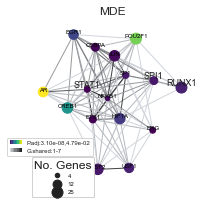

<Figure size 216x216 with 0 Axes>

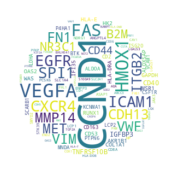

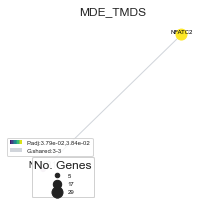

<Figure size 216x216 with 0 Axes>

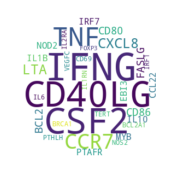

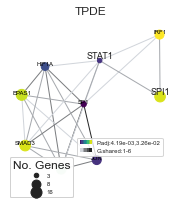

<Figure size 216x216 with 0 Axes>

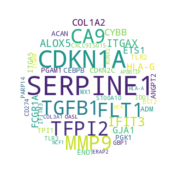

--------------------------------------------------------------------------------
Note, there are no edges drawn since there were no overlaps. Ensure you selected the overlap column correctly, you input:	gene_names	 with the separator:	_	
--------------------------------------------------------------------------------


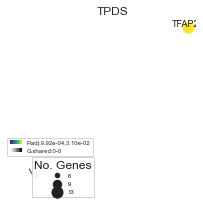

<Figure size 216x216 with 0 Axes>

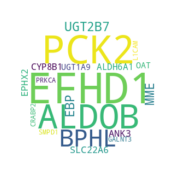

In [10]:
#from scimotf import plot_cluster_tf
from scipy.stats import fisher_exact
from statsmodels.stats.multitest import multipletests
from sciutil import SciUtil, SciException
from sciviso import Emapplot
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
from wordcloud import WordCloud
import seaborn as sns
plot_cluster_tf(f'{output_dir}scimotif_DORO_A.csv', save_fig=True, fig_dir=output_dir)

## Format the ChIP peaks from ChIP atlas

In [4]:
# Read the bed files and save the 3 separate files for HIF1A
# 1) RCC kidney 2) other kidney, 3) all other tissues
# https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE120887 good study 
chip_dir = f'{base_dir}/raw_downloads/ChIP_atlas/'
with open(f'{chip_dir}Oth.ALL.05.HIF1A.AllCell.bed', 'r') as f:
    with open(f'files/HIF1A_kidney_RCC.bed', 'w+') as rcc:
        with open(f'files/HIF1A_kidney_other.bed', 'w+') as kidney:
            with open(f'files/HIF1A_OTHER.bed', 'w+') as all_other:
                first = True
                for line in f:
                    line = line.replace('%20', '').replace('@', '')
                    if first:
                        rcc.write(line)
                        kidney.write(line)
                        all_other.write(line)
                        first = False
                    else:
                        if 'Title=GSM2723878' in line or ('RCC' in line and 'Title' in line):
                            rcc.write(line)
                        elif 'group=Kidney' in line:
                            kidney.write(line)
                        else:
                            all_other.write(line)

In [5]:
# Read the bed files and save the 3 separate files for HIF1A
# 1) RCC kidney 2) other kidney, 3) all other tissues
# https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE120887 good study 
with open(f'{chip_dir}Oth.ALL.05.EPAS1.AllCell.bed', 'r') as f:
    with open(f'files/HIF1B-EPAS1_kidney_RCC.bed', 'w+') as rcc:
        with open(f'files/HIF1B-EPAS1_kidney_other.bed', 'w+') as kidney:
            with open(f'files/HIF1B-EPAS1_OTHER.bed', 'w+') as all_other:
                first = True
                for line in f:
                    line = line.replace('%20', '').replace('@', '')
                    if first:
                        rcc.write(line)
                        kidney.write(line)
                        all_other.write(line)
                        first = False
                    else:
                        if 'Title=GSM1642766' in line or ('RCC' in line and 'Title' in line):
                            rcc.write(line)
                        elif 'group=Kidney' in line:
                            kidney.write(line)
                        else:
                            all_other.write(line)

## Use IGV to view genes

In [6]:
import igv

b = igv.Browser({"genome": "hg38"})
b.show()

# Load HIF1A and HIF1B/EPAS1
b.load_track(
    {
        "name": "HIF1A RCC",
        "url": 'files/HIF1A_kidney_RCC.bed',
        "format": "bed",
        "type": "annotation",
        "sourceType": "file",
        "indexed": False,
        "displayMode": "EXPANDED",
        "color": "#b91c1c" #"#e58f35" # same colour as TPDE
    })

b.load_track(
    {
        "name": "EPAS1 RCC",
        "url": 'files/HIF1B-EPAS1_kidney_RCC.bed',
        "format": "bed",
        "type": "annotation",
        "sourceType": "file",
        "indexed": False,
        "displayMode": "EXPANDED",
        "color": "#93c5fd" #"#e58f35" # same colour as TPDE
    })
